In [1]:
from pathlib import Path

In [2]:
! ls 

__notebook__.ipynb


In [3]:
cat_images = list(Path("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n02124075").rglob("*.JPEG"))

In [4]:
from PIL import Image

In [5]:
import cv2
import numpy as np

In [6]:
import random

In [7]:
i = random.randint(0, len(cat_images))

In [8]:
i = 1092

1092


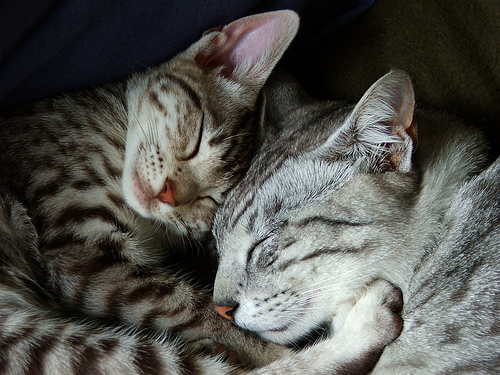

In [9]:
print(i)
image = Image.open(cat_images[i])
image.save("sharp1.png")
image

850


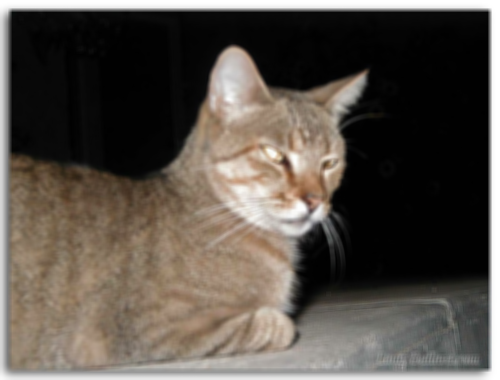

In [10]:
j = random.randint(0, len(cat_images))
print(j)
image_blurred = cv2.blur(np.array(Image.open(cat_images[j])),
                         (5, 5))
image_blurred = Image.fromarray(image_blurred)
image_blurred.save("blurry.png")
image_blurred

In [11]:
from skimage.filters import laplace

In [12]:
np.array(image).dtype

dtype('uint8')

0.055484506396685014


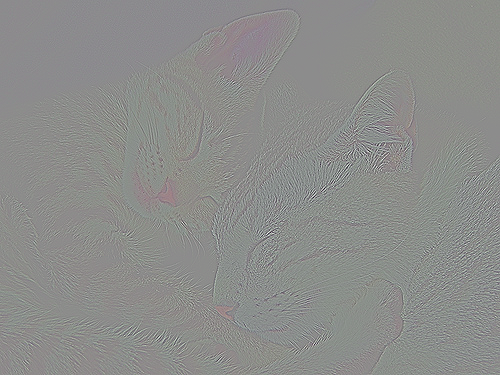

In [13]:
l = np.array(image).astype("float64")
l -= l.min()
l /= l.max()
l = laplace(l)
print(l.var())
l -= l.min()
l /= l.max()
l *= 255
l_sharp = l.astype('uint8')

image_laplace = Image.fromarray(l_sharp)
image_laplace.save("laplace_sharp.png")
image_laplace

0.0021383441456389904


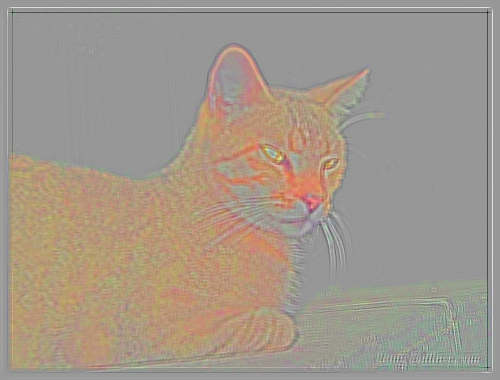

In [14]:
l = np.array(image_blurred).astype("float64")
l -= l.min()
l /= l.max()
l = laplace(l)
print(l.var())
l -= l.min()
l /= l.max()
l *= 255
l_blurry = l.astype('uint8')

image_laplace = Image.fromarray(l_blurry)
image_laplace.save("laplace_blurred.png")
image_laplace

In [15]:
images = random.sample(cat_images, 30)

In [16]:
sharp_image_paths = images[:15]
blurry_image_paths = images[15:]

In [17]:
assert len(sharp_image_paths) == len(blurry_image_paths)

In [18]:
sharp_images = [np.array(Image.open(p)) for p in sharp_image_paths]
blurry_images = [cv2.blur(np.array(Image.open(p)), (k, k)) 
                 for p, k in zip(sharp_image_paths,
                                 [random.randint(3, 5)
                                  for i in range(len(sharp_image_paths))])]

In [19]:
sharp_images_variance = [laplace(s).var() for s in sharp_images]
blurry_images_variance = [laplace(b).var() for b in blurry_images]

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator, FixedFormatter

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


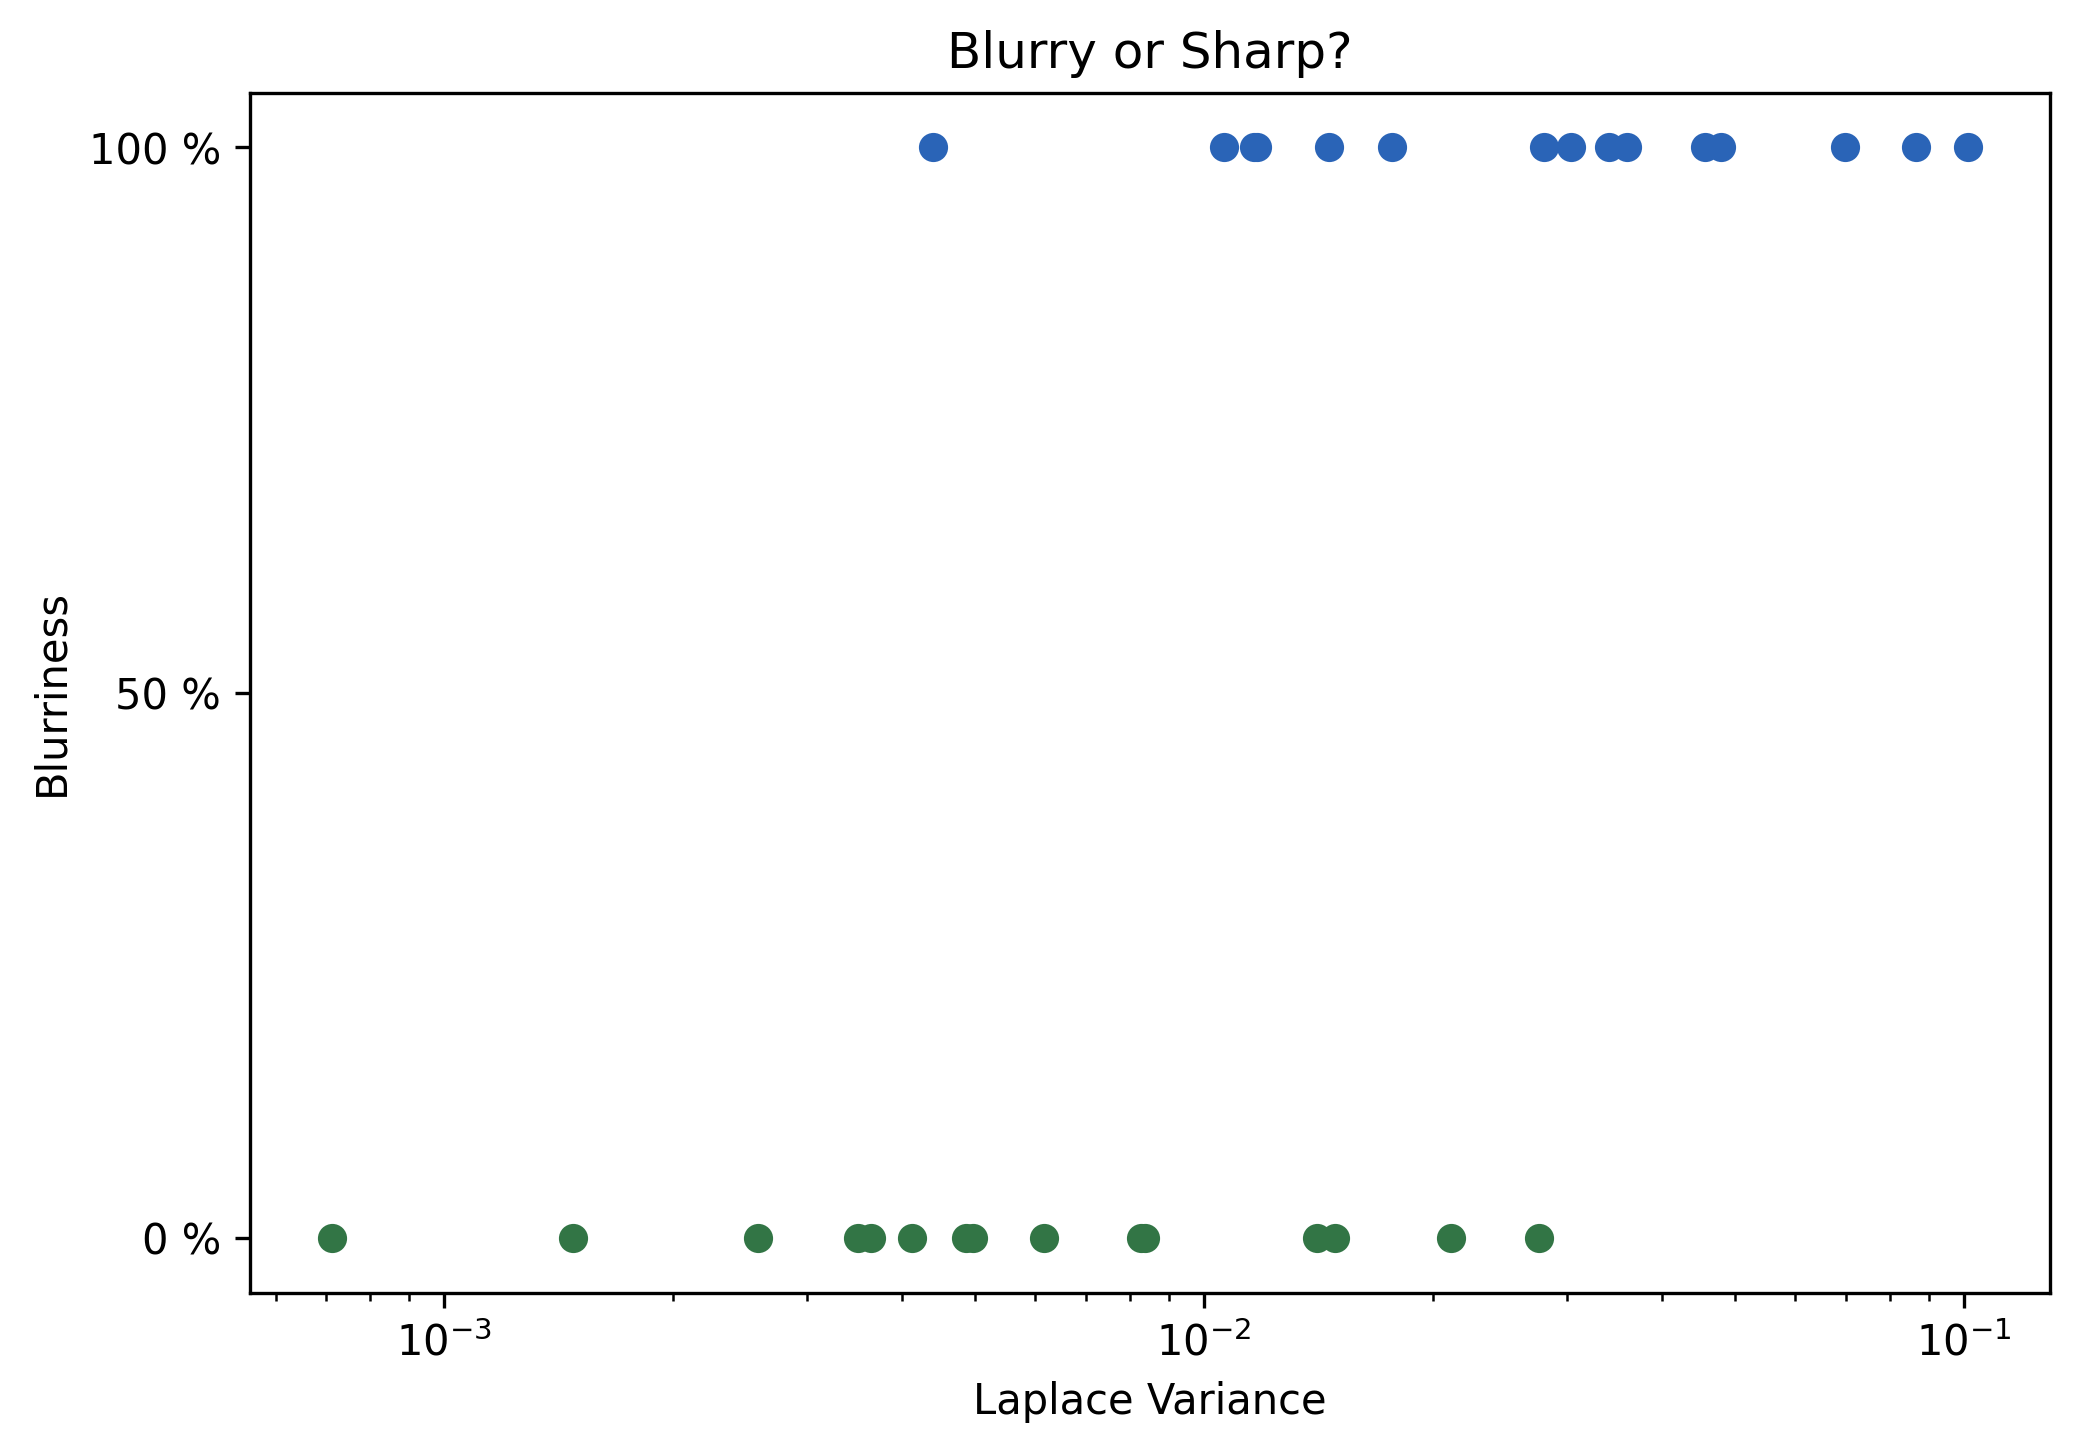

In [21]:
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(False)
ax.scatter(sharp_images_variance, [1 for i in range(len(blurry_images_variance))], label="Blurry", c="#2A64B7")
ax.scatter(blurry_images_variance, [0 for i in range(len(sharp_images_variance))], label="Sharp", c="#327545")
ax.set_xlabel("Laplace Variance")
ax.set_xscale("log")
ax.set_ylabel("Blurriness")
ax.set_title("Blurry or Sharp?")

y_formatter = FixedFormatter(["0 %", "50 %", "100 %"])
y_locator = FixedLocator([0, 0.5, 1])
ax.yaxis.set_major_formatter(y_formatter)
ax.yaxis.set_major_locator(y_locator)

plt.savefig("blurry_or_sharp.png", bbox_inches='tight', pad_inches=0, transparent=True)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [23]:
x = np.hstack([sharp_images_variance, blurry_images_variance])[:, None]
y = np.hstack([[1 for i in range(len(sharp_images))],
               [0 for i in range(len(sharp_images))]])

In [24]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(x)

In [25]:
clf = LogisticRegression(penalty='none').fit(X_transformed, y)

In [26]:
w = clf.coef_[0][0]
b = clf.intercept_[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


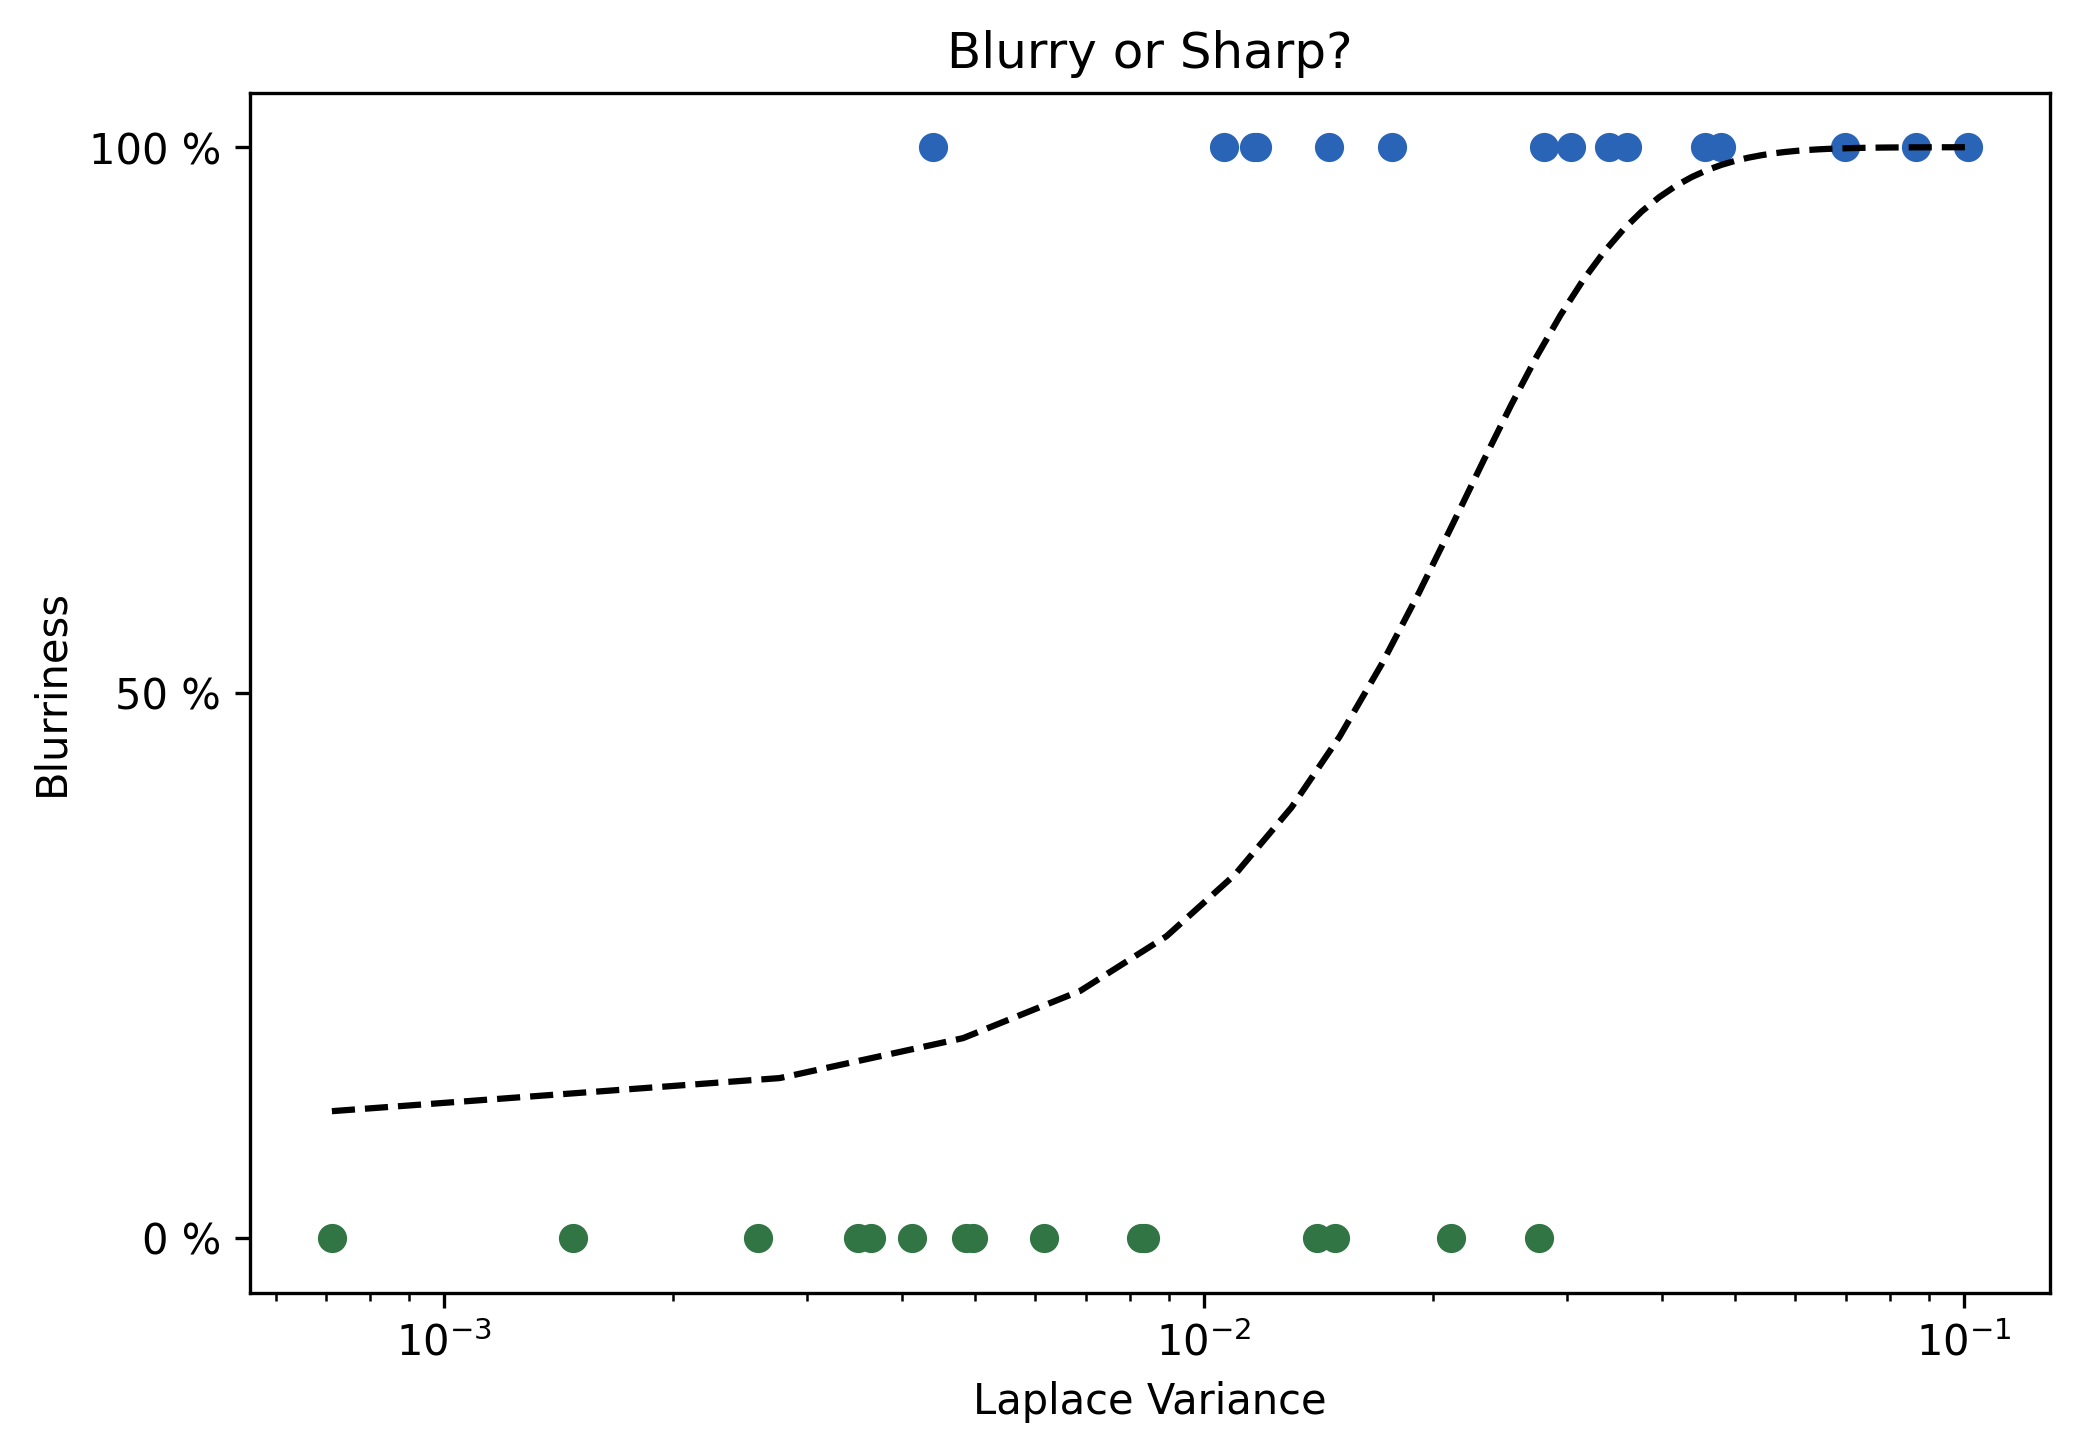

In [27]:
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(False)
model = np.linspace(x.min(), x.max())
ax.plot(model,
        1 / (1 + np.exp(-(w * scaler.transform(model[:, None]) + b))), 
        label="Prediction", c="#000", linestyle="--")
ax.scatter(sharp_images_variance, [1 for i in range(len(blurry_images_variance))], label="Blurry", c="#2A64B7")
ax.scatter(blurry_images_variance, [0 for i in range(len(sharp_images_variance))], label="Sharp", c="#327545")
ax.set_xlabel("Laplace Variance")
ax.set_xscale("log")
ax.set_ylabel("Blurriness")
ax.set_title("Blurry or Sharp?")

y_formatter = FixedFormatter(["0 %", "50 %", "100 %"])
y_locator = FixedLocator([0, 0.5, 1])
ax.yaxis.set_major_formatter(y_formatter)
ax.yaxis.set_major_locator(y_locator)

plt.savefig("blurry_or_sharp_prediction.png", bbox_inches='tight', pad_inches=0, transparent=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


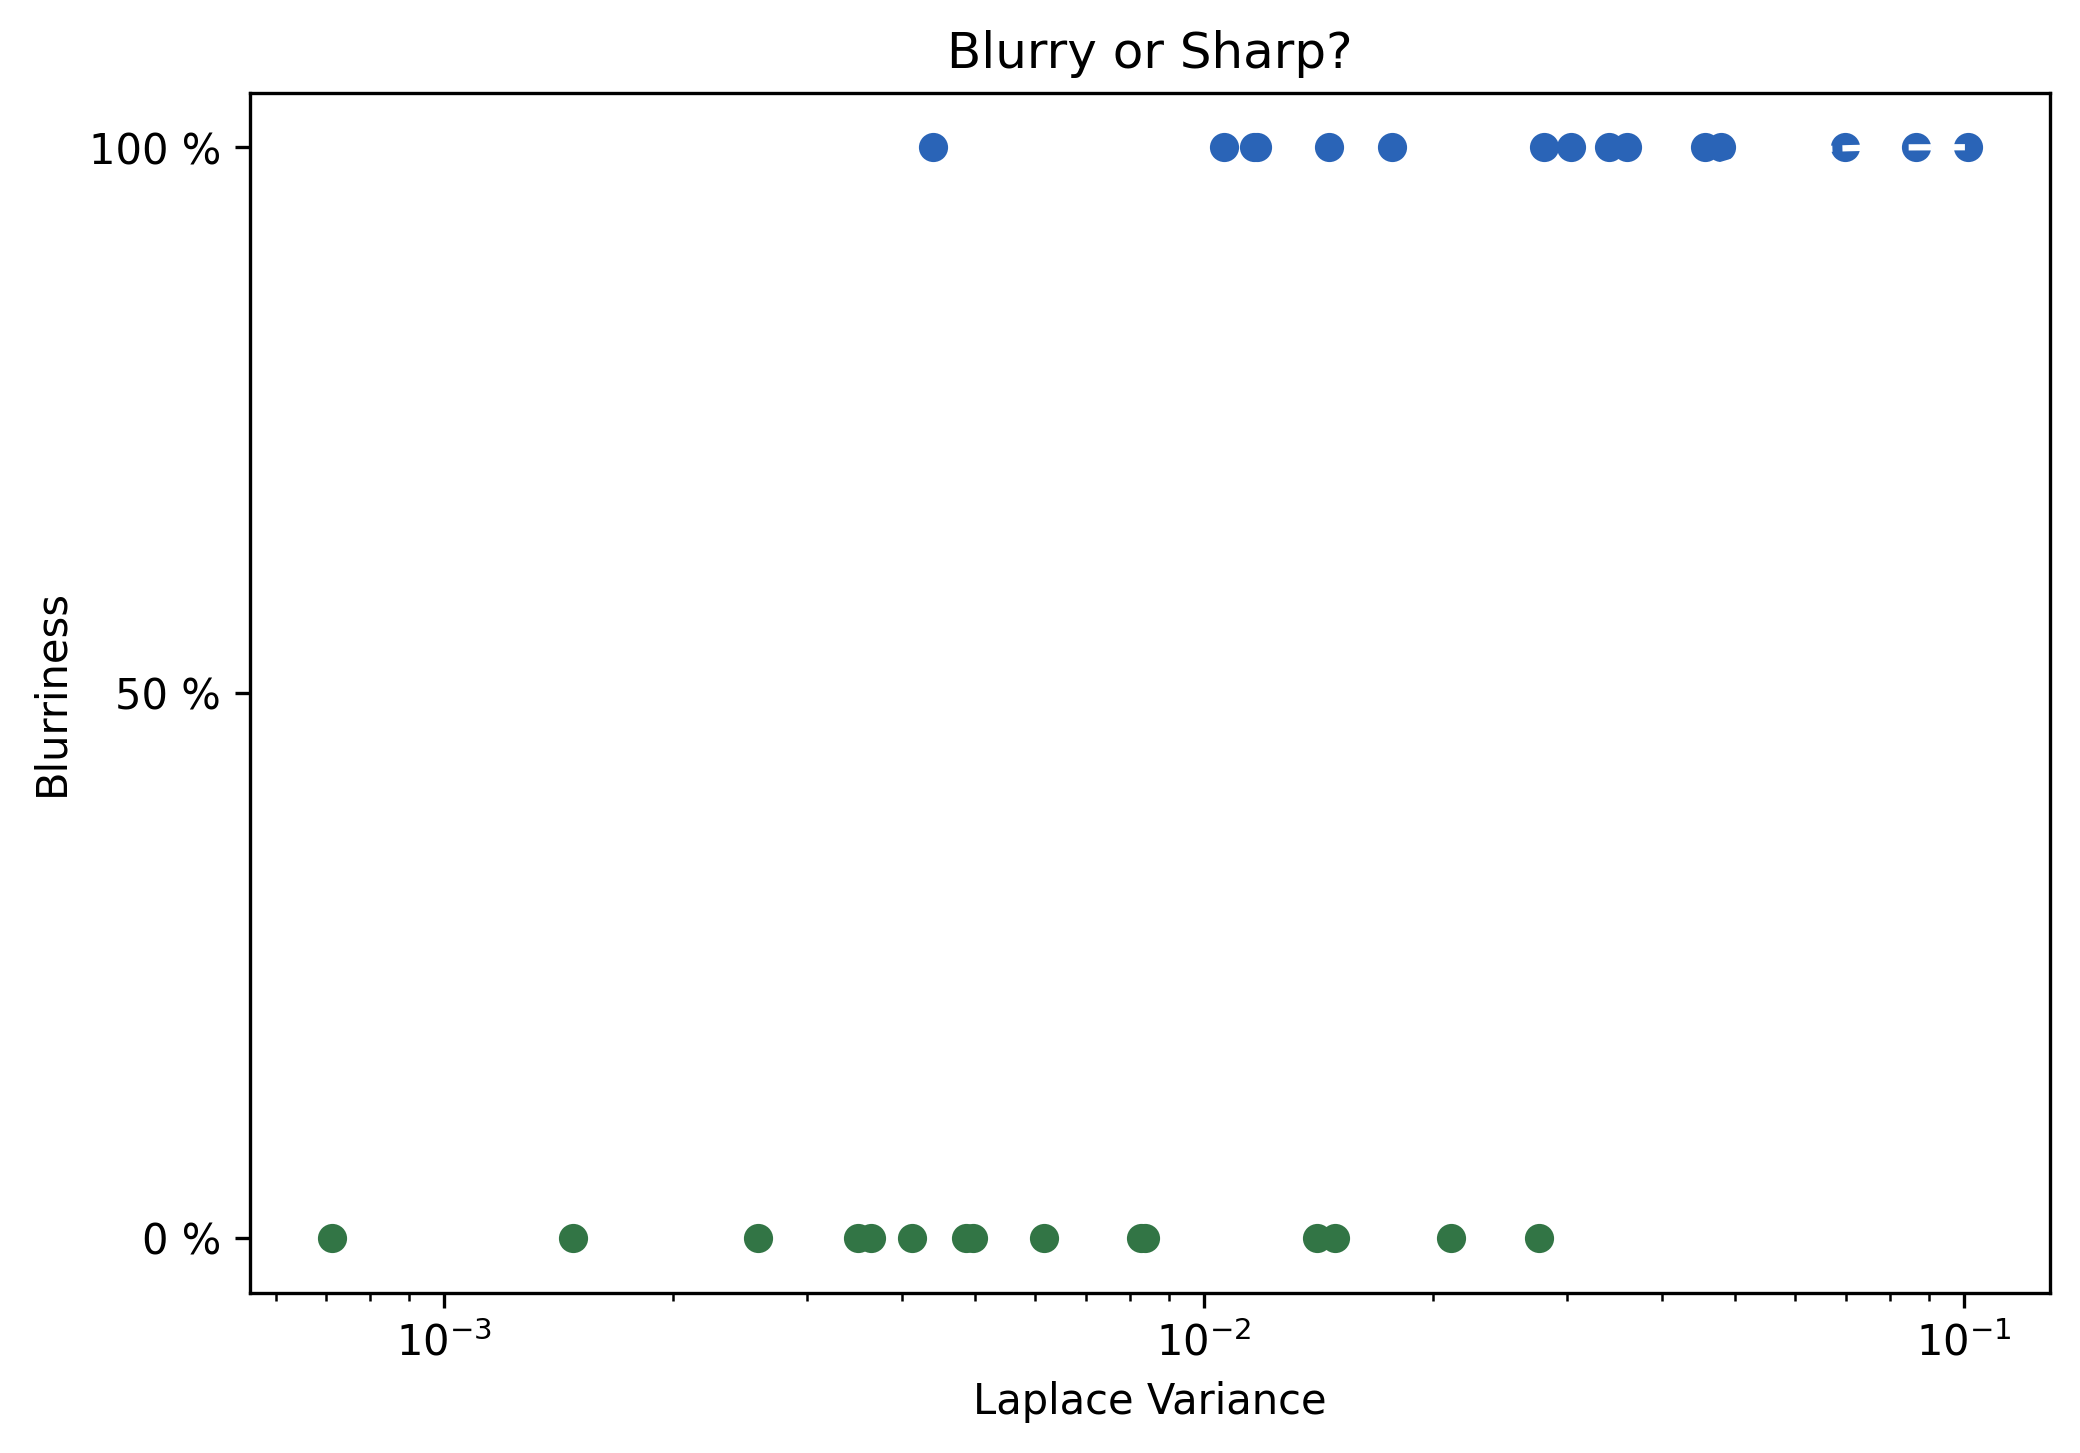

In [28]:
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(False)
model = np.linspace(x.min(), x.max())
ax.plot(model,
        1 / (1 + np.exp(-(w * scaler.transform(model[:, None]) + b))), 
        label="Prediction", c="#fff", linestyle="--")
ax.scatter(sharp_images_variance, [1 for i in range(len(blurry_images_variance))], label="Blurry", c="#2A64B7")
ax.scatter(blurry_images_variance, [0 for i in range(len(sharp_images_variance))], label="Sharp", c="#327545")
ax.set_xlabel("Laplace Variance")
ax.set_xscale("log")
ax.set_ylabel("Blurriness")
ax.set_title("Blurry or Sharp?")

y_formatter = FixedFormatter(["0 %", "50 %", "100 %"])
y_locator = FixedLocator([0, 0.5, 1])
ax.yaxis.set_major_formatter(y_formatter)
ax.yaxis.set_major_locator(y_locator)

plt.savefig("blurry_or_sharp_prediction.png", bbox_inches='tight', pad_inches=0, transparent=True)